In [1]:
import cvxpy as cp
import numpy as np
import itertools
import pickle


class OptimizationProblem:
    def __init__(self, K, R, L, lmbda=None, b=None, verbose=1, tolerance=1e-8):
        self.K = K
        self.R = R
        self.L = L
        self.verbose = verbose
        self.tolerance = tolerance

        # If b is not provided, generate a random one
        self.b = b if b is not None else np.ones(K) * np.random.rand(1) / (10 * K)

        # If lmbda is not provided, generate a random one and set the first element to 1
        self.lmbda = lmbda if lmbda is not None else np.random.rand(K + 1)
        self.lmbda[0] = 1

        self.a = np.zeros(K + 1)
        self.a[0] = 1
        self.A = np.zeros(K + 1)
        self.A[0] = 1
        self.theta = np.zeros((K, K))

        self._calculate_sequences()
        self._define_matrices()

        # To store the solution
        self.status = None
        self.v_i_value = None
        self.v_si_value = None
        self.u_value = None
        self.u_theoretical = None

    def _calculate_sequences(self):
        for i in range(self.K):
            self.a[i + 1] = (
                self.lmbda[i + 1]
                + np.sqrt(4 * self.lmbda[i + 1] * self.A[i] + self.lmbda[i + 1] ** 2)
            ) / 2
            self.A[i + 1] = self.A[i] + self.a[i + 1]

        for k in range(self.K):
            for i in range(self.K):
                if i == k:
                    self.theta[k, i] = (
                        1 + (2 * self.a[k] - 1) * self.a[k + 1] / self.A[k + 1]
                    )
                else:
                    if i > k:
                        break
                    self.theta[k, i] = (self.a[k + 1] / self.A[k + 1]) * (
                        2 * self.a[i] - self.theta[k - 1, i]
                    ) + self.theta[k - 1, i]

    def _define_matrices(self):
        K = self.K
        L = self.L

        self.dimG = 2 * K + 2
        self.dimF = K + 1

        self.f = np.matrix(np.eye(K + 1))
        self.fs = np.zeros((K + 1, 1))

        self.xs = np.zeros((2 * K + 2, 1))

        self.e = np.matrix(np.zeros((2 * K + 2, K)))
        self.e[1 : K + 1, :] = np.eye(K)
        self.g = np.matrix(np.zeros((2 * K + 2, K + 1)))
        self.g[K + 1 :, :] = np.eye(K + 1)
        self.gs = np.zeros((2 * K + 2, 1))

        self.xi = np.matrix(np.zeros((2 * K + 2, K + 1)))
        self.xi[0] = 1

        for k in range(K):
            temp = self.xi[:, 0]
            for i in range(k + 1):
                temp = temp - 1 / L * self.theta[k, i] * (self.e[:, i] + self.g[:, i])
            self.xi[:, k + 1] = temp

    def solve(self):
        K = self.K
        L = self.L
        R = self.R
        tolerance = self.tolerance

        v_i = cp.Variable((K), nonneg=True)
        v_si = cp.Variable(K + 1, nonneg=True)
        tau = cp.Variable(1, nonneg=True)
        u = cp.Variable(K, nonneg=True)
        E = cp.Variable(1, nonneg=True)

        constraints = [
            v_i == self.A[0:K] / self.A[K],
            v_si >= 0,
            tau == L / (4 * self.A[K]),
            u >= 0,
        ]

        func_linear = self.f[:, -1] + v_si[K] * (self.fs - self.f[:, K])
        for i in range(K):
            func_linear = (
                func_linear
                + v_i[i] * (self.f[:, i] - self.f[:, i + 1])
                + v_si[i] * (self.fs - self.f[:, i])
            )

        func_PSD = (
            tau * self.xi[:, 0] @ self.xi[:, 0].T
            + 1 / (2 * L) * self.g[:, K] @ self.g[:, K].T
        )

        for i in range(K):
            Aij = (
                1
                / 2
                * (
                    (self.xi[:, i] - self.xi[:, i + 1]) @ self.g[:, i + 1].T
                    + self.g[:, i + 1] @ (self.xi[:, i] - self.xi[:, i + 1]).T
                )
                + 1
                / (2 * L)
                * (self.g[:, i] - self.g[:, i + 1])
                @ (self.g[:, i] - self.g[:, i + 1]).T
            )
            Asi = (
                1
                / 2
                * (
                    (self.xs - self.xi[:, i]) @ self.g[:, i].T
                    + self.g[:, i] @ (self.xs - self.xi[:, i]).T
                )
                + 1 / (2 * L) * (self.gs - self.g[:, i]) @ (self.gs - self.g[:, i]).T
            )
            func_PSD = (
                func_PSD
                + v_i[i] * Aij
                + v_si[i] * Asi
                + u[i] * self.e[:, i] @ self.e[:, i].T
            )

        i = K
        Asi = (
            1
            / 2
            * (
                (self.xs - self.xi[:, i]) @ self.g[:, i].T
                + self.g[:, i] @ (self.xs - self.xi[:, i]).T
            )
            + 1 / (2 * L) * (self.gs - self.g[:, i]) @ (self.gs - self.g[:, i]).T
        )
        func_PSD = func_PSD + v_si[i] * Asi

        constraints += [func_linear == 0]
        constraints += [func_PSD >> 0]
        obj = cp.Minimize(self.b @ u)

        solver_opt = {
            "solver": "MOSEK",
            "verbose": self.verbose,
            "mosek_params": {"MSK_DPAR_INTPNT_CO_TOL_PFEAS": tolerance},
        }
        prob = cp.Problem(obj, constraints)
        prob.solve(**solver_opt)

        # Store the solution in the class attributes
        self.status = prob.status
        self.v_i_value = v_i.value
        self.v_si_value = v_si.value
        self.u_value = u.value

        # # Print status
        # print("status:", self.status)
        # print("max absolute difference in v_i:", max(abs(self.v_i_value - self.A[0:self.K] / self.A[self.K])))
        # print("absolute value of E:", abs(self.E_value))

        # return self.status, self.v_i_value, self.E_value

    def calculate_u(self):
        A = np.append(self.A, 0)
        alpha = self.a
        L = self.L
        K = self.K
        u_theoretical = [0 for i in range(K)]
        for i in range(K):
            u = (
                A[i]
                * (1 + 2 * alpha[i + 1])
                * (A[i] + 2 * alpha[i] * alpha[i + 1])
                / (4 * L * A[K] * (A[i + 1] - alpha[i + 1] ** 2))
            )
            for k in range(i + 1, K):
                u = u + A[k] * (1 + 2 * alpha[k + 1]) * alpha[i] * alpha[k + 1] / (
                    2 * L * A[K] * (A[k + 1] - alpha[k + 1] ** 2)
                )
            u_theoretical[i] = u
        self.u_theoretical = u_theoretical


# # Example usage with custom lmbda and b
K = 10
lmbda = np.array([1] + list(np.random.rand(K)))
# # lmbda = np.random.rand(K+1)
# b = np.random.rand(K) * 1

opt_problem = OptimizationProblem(K=K, R=10, L=5, lmbda=lmbda, verbose=0)
opt_problem.solve()
opt_problem.calculate_u()
(opt_problem.u_theoretical - opt_problem.u_value) / opt_problem.u_theoretical

array([-4.65160370e-05, -4.87090604e-06, -4.95097428e-05, -3.31731704e-05,
        8.19115734e-06,  3.65531279e-05, -3.12706840e-05,  4.24826422e-05,
        1.09572847e-05,  4.38825476e-05])

In [62]:
# Define the ranges of K, R, and L values
K_values = np.linspace(10, 100, 10, dtype=int)
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]

# Generate all combinations of K, R, and L values
combinations = itertools.product(K_values, R_values, L_values)

# Number of random lambda and b values to generate for each combination
N = 10

# To store the class instances for each combination and each random setting
opt_problems = {}

# Set a random seed for reproducibility
np.random.seed(6)

# Repeat the experiment for different values of K, R, L and save the class instance
for i, (K, R, L) in enumerate(combinations):
    for j in range(N):
        # Generate random lambda and b values
        lmbda = np.random.rand(K + 1) * 0.9
        lmbda[0] = 1
        b = np.ones(K) * np.random.rand(1) / K

        # Create a new OptimizationProblem instance with the generated parameters
        opt_problem_key = (i, j)
        opt_problems[opt_problem_key] = OptimizationProblem(
            K=K, R=R, L=L, lmbda=lmbda, b=b, verbose=0
        )

        # Solve the optimization problem
        opt_problems[opt_problem_key].solve()
        opt_problems[opt_problem_key].calculate_u()

        # Print the results for this setting
        print(f"Setting {opt_problem_key}: K={K}, R={R}, L={L}")
        print("Status:", opt_problems[opt_problem_key].status)
        print(
            "Max error of u:",
            max(
                abs(
                    opt_problems[opt_problem_key].u_value
                    - opt_problems[opt_problem_key].u_theoretical
                )
                / opt_problems[opt_problem_key].u_theoretical
            ),
        )
        print("\n")

# Save the results with pickle
with open("opt_problems_u.pickle", "wb") as handle:
    pickle.dump(opt_problems, handle, protocol=pickle.HIGHEST_PROTOCOL)

Setting (0, 0): K=10, R=1, L=1
Status: optimal
Max error of u: 3.244662458940651e-05


Setting (0, 1): K=10, R=1, L=1
Status: optimal
Max error of u: 5.080425102882818e-05


Setting (0, 2): K=10, R=1, L=1
Status: optimal
Max error of u: 4.254134526049416e-05


Setting (0, 3): K=10, R=1, L=1
Status: optimal
Max error of u: 3.202376031294398e-05


Setting (0, 4): K=10, R=1, L=1
Status: optimal
Max error of u: 7.5843680703126265e-06


Setting (0, 5): K=10, R=1, L=1
Status: optimal
Max error of u: 9.869216196991712e-05


Setting (0, 6): K=10, R=1, L=1
Status: optimal
Max error of u: 0.00016677460206322812


Setting (0, 7): K=10, R=1, L=1
Status: optimal
Max error of u: 9.55418050274976e-05


Setting (0, 8): K=10, R=1, L=1
Status: optimal
Max error of u: 0.000104649855936743


Setting (0, 9): K=10, R=1, L=1
Status: optimal
Max error of u: 7.486501909343134e-05


Setting (1, 0): K=10, R=1, L=10
Status: optimal
Max error of u: 3.558597974000356e-05


Setting (1, 1): K=10, R=1, L=10
Status: op

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "ps.usedistiller": "xpdf",
    }
)

# Load the two results with pickle and combine them
with open("opt_problems_u.pickle", "rb") as handle:
    opt_problems = pickle.load(handle)


# Plot the results as K be the x-axis,  Max error of v_i as y-axis, and average over all N random settings of b and lmbda, (R,L) as different lines
K_values = list(np.linspace(10, 100, 10, dtype=int))
R_values = [1, 10, 1000]
L_values = [1, 10, 1000]
combinations = itertools.product(K_values, R_values, L_values)
N = 10
max_errors = np.zeros((len(K_values), len(R_values), len(L_values)))


for i, (K, R, L) in enumerate(combinations):
    errors = []
    for j in range(N):

        opt_problem_key = (i, j)
        errors.append(
            np.linalg.norm(
                opt_problems[opt_problem_key].u_value
                - opt_problems[opt_problem_key].u_theoretical
            )
            / np.linalg.norm(opt_problems[opt_problem_key].u_theoretical)
        )

        max_errors[K_values.index(K), R_values.index(R), L_values.index(L)] = np.mean(
            errors
        )

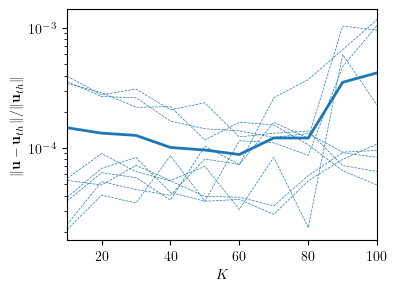

In [5]:
fig, ax = plt.subplots(figsize=(4,3))

for j, R in enumerate(R_values):
    for k, L in enumerate(L_values):
        ax.plot(K_values, max_errors[:, j, k], label=f"R={R}, L={L}",linestyle='--',color = 'C0',alpha=1,linewidth=0.5)

# plot the average over the above lines
ax.plot(K_values, np.mean(max_errors, axis=(1, 2)), label="Average", color="C0", linewidth=2)


ax.set_xlabel(r"$K$")
ax.set_ylabel(r"$\|\mathbf{u} - \mathbf{u}_{th}\| / \| \mathbf{u}_{th}\|$")
ax.set_yscale("log")
ax.set_xlim([10, 100])
# ax.legend()

plt.savefig("Figures/u_error.pdf", bbox_inches="tight")

In [65]:
max_errors[:, 1, 2]

array([3.43334236e-04, 2.87944010e-04, 2.17643280e-04, 2.19933921e-04,
       1.16115302e-04, 1.63365386e-04, 1.54947419e-04, 1.05924103e-04,
       6.44327298e-05, 4.89622431e-05])